## Sample MRS acceleration Tutorial

This notebook is a tutorial for a simple implementation on how to create a machine learning model to accelerate GABA Edited-MRS

The model we'll use will receive as input difference transients in the frequency domain and output a single difference spectrum. In other words, it's only performing the denoising and combination of the difference transients. An important note is that this is only one of the possible options, the acceleration could also be done with one model per subspectra, or in the time domain, for example.

In [4]:
# Changing path to access scripts
import sys
sys.path.insert(0,"..")

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Verify cuda
torch.cuda.is_available()

True

### Data Loading

The first thing we'll need to do is loading the data, which is stored as ground truth fids in a numpy file. We'll then add noise to the fids, using the same code as in the `noise_adding_tutorial`, generating our noisy transients this way.

After obtaining the transients, we'll normalize both the x and y data and divide them into training and testing datasets.

In [6]:
### load sample data
with h5py.File("../data/sample_data.h5") as hf:
    gt_fids = hf["ground_truth_fids"][()]
    ppm = hf["ppm"][()]
    t = hf["t"][()]

# transforming into frequency domain to use as the target data
gt_spec = np.fft.fftshift(np.fft.ifft(gt_fids,axis=1),axes=1)


####  Adding Noise ####
#Expand to new dimension and add 40 transients per subspectra
noise_fid = np.expand_dims(gt_fids.copy(),axis=3)
noise_fid = np.repeat(noise_fid,40,axis=3)

# Amplitude noise
base_amplitude_noise = 10
amplitude_noise = np.random.normal(0,base_amplitude_noise,size=noise_fid.shape)
noise_fid = noise_fid+amplitude_noise

# frequency noise
freq_shift_std=20
freq_shifts = np.random.normal(0,freq_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(freq_shifts*t.reshape(t.shape[0],t.shape[1],1,1)*math.pi/2))

# phase noise
phase_shift_std=30
phase_shifts = np.random.normal(0,phase_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(phase_shifts*np.ones((t.shape[0],t.shape[1],1,1))*math.pi/180))
#### Finish Adding Noise ####

# Note: The parameters to add noise and the way noise is added directly affects
# the results and the objective is to be as close as possible to in vivo data.

# Transforming time domain noisy transients into frequency domain difference transients
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[:,:,1,:]-noise_spec[:,:,0,:]

# initial definition of input and target data
x = np.real(noise_diff_spec)
y = np.real(gt_spec[:,:,1]-gt_spec[:,:,0]) # editing process in subtraction

# normalizing using minimum of region of most interest and total maximum.
x_max = x.max(axis=(1,2),keepdims=True)
x_mean = x[:,900:1100].min(axis=(1,2),keepdims=True)

y_max = y.max(axis=(1),keepdims=True)
y_mean = y[:,900:1100].min(axis=(1),keepdims=True)

x = (x-x_mean)/(x_max-x_mean)
y = (y-y_mean)/(y_max-y_mean)

# expanding dimensions for compatibility with U-NET
x = np.expand_dims(x,axis=3)


# division of training and testing data
x_train = x[:int(x.shape[0]*0.8)]
x_test = x[int(x.shape[0]*0.8):]

y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

ppm_train = ppm[:int(ppm.shape[0]*0.8)]
ppm_test = ppm[int(ppm.shape[0]*0.8):]

# The section above was the same as the tensorflow tutorial,
# now we will convert tje data to torch formats.

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

ppm_train = torch.from_numpy(ppm_train)
ppm_test = torch.from_numpy(ppm_test)


### Sample Model Used

In this tutorial, we'll use a simple 2D U-net to combine the transients, considering the transients as a 2D "image" (spectral_points x transients). 

In [7]:
# We'll declare our model as a class
class UNET(nn.Module):

    # initializing the weights for the convolution layers
    def __init__(self,transient_count):
        super(UNET,self).__init__()

        self.down_conv_1_1 = nn.Conv2d(1,16,kernel_size=(5,1),padding="same")
        self.down_conv_1_2 = nn.Conv2d(16,16,kernel_size=(3,3),padding="same")

        self.down_conv_2_1 = nn.Conv2d(16,32,kernel_size=(3,3),padding="same")
        self.down_conv_2_2 = nn.Conv2d(32,32,kernel_size=(3,3),padding="same")

        self.down_conv_3_1 = nn.Conv2d(32,64,kernel_size=(3,3),padding="same")
        self.down_conv_3_2 = nn.Conv2d(64,64,kernel_size=(3,3),padding="same")

        self.up_conv_1_1 = nn.Conv2d(64,128,kernel_size=(3,3),padding="same")
        self.up_conv_1_2 = nn.Conv2d(128,128,kernel_size=(3,3),padding="same")

        self.up_conv_2_1 = nn.Conv2d(192,64,kernel_size=(3,3),padding="same")
        self.up_conv_2_2 = nn.Conv2d(64,64,kernel_size=(3,3),padding="same")

        self.up_conv_3_1 = nn.Conv2d(96,32,kernel_size=(3,3),padding="same")
        self.up_conv_3_2 = nn.Conv2d(32,32,kernel_size=(3,3),padding="same")

        self.end_conv_1_1 = nn.Conv2d(48,128,kernel_size=(1,transient_count))
        self.end_conv_1_2 = nn.Conv2d(128,1,kernel_size=(5,5),padding="same")
    
    # defining forward pass
    def forward(self,x):
        
        # changing order of dimensions, as in torch the filters come first
        y = x.transpose(1,3)
        y = y.transpose(2,3)

        y = F.relu(self.down_conv_1_1(y))
        y_skip1 = F.relu(self.down_conv_1_2(y))

        y = F.max_pool2d(y_skip1,(2,1))

        y = F.relu(self.down_conv_2_1(y))
        y_skip2 = F.relu(self.down_conv_2_2(y))

        y = F.max_pool2d(y_skip2,(2,1))

        y = F.relu(self.down_conv_3_1(y))
        y_skip3 = F.relu(self.down_conv_3_2(y))

        y = F.max_pool2d(y_skip3,(2,1))

        y = F.relu(self.up_conv_1_1(y))
        y = F.relu(self.up_conv_1_2(y))

        y = F.upsample(y,scale_factor=(2,1))

        y = torch.concat([y,y_skip3],axis=1)

        y = F.relu(self.up_conv_2_1(y))
        y = F.relu(self.up_conv_2_2(y))

        y = F.upsample(y,scale_factor=(2,1))

        y = torch.concat([y,y_skip2],axis=1)

        y = F.relu(self.up_conv_3_1(y))
        y = F.relu(self.up_conv_3_2(y))

        y = F.upsample(y,scale_factor=(2,1))

        y = torch.concat([y,y_skip1],axis=1)

        y = F.relu(self.end_conv_1_1(y))
        y = self.end_conv_1_2(y)

        # converting the order of layers back to the original format

        y = y.transpose(1,3)
        y = y.transpose(1,2)

        # flattening result to only have 2 dimensions
        return y.view(y.shape[0],-1)

# We'll use a mean average loss applied to a specific range for a loss function
class RangeMAELoss(nn.Module):

    def __init__(self):
        super(RangeMAELoss,self).__init__()

    
    # for the forward pass, a 1d ppm array must be passed and it's assumed that
    # it's valid for all sets
    def forward(self,x,y,ppm):
        
        # defining indexes of boundaries
        min_ind = torch.argmax(ppm[ppm<=4])
        max_ind = torch.argmin(ppm[ppm>=2.5])

        # selecting part of arrays pertaining to region of interest
        loss_x = x[:,min_ind:max_ind]
        loss_y = y[:,min_ind:max_ind]

        #calculate absolute loss mean value
        loss = torch.abs(loss_x-loss_y).mean(dim=1).mean(axis=0)

        return loss

# Simple dataset used to iterate over data
class BasicDataset(Dataset):
    def __init__(self,x,y,ppm):
        super(BasicDataset,self).__init__()

        self.x = x
        self.y = y
        self.ppm = ppm

    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self,idx):

        return self.x[idx],self.y[idx],self.ppm[idx]


### Setting Up model

We'll instantiate the model using the same number of transients we've been using for our data, 40 transients. 

In [8]:
# instantiate model and make it use float values for avoiding incompatibilities
model = UNET(40).float()

### Training Loop

We'll instantiate the necessary objects for a training loop and perfom the optimization of our model's weights

In [9]:
# defining dataset and loader
train_dataset = BasicDataset(x_train,y_train,ppm_train)
train_dataloader = DataLoader(train_dataset,10,shuffle=True)

# defining loss, optimizer and setting learning rate to change over time
loss_fn = RangeMAELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim,lambda lr: 0.5)
lr_scheduler_freq=20


# define the device to perform training, in case cuda is available
device="cuda"
model.to(device)
loss_fn.to(device)
model.train()

# defining amount of epochs
epoch_count=100

# define if should train or load pre-trained weights
skip_train=True#False


if skip_train:
    model.load_state_dict(torch.load("torch_weights.pth"))
else:
    for epoch in range(0,epoch_count):

        epoch_losses = []
        for x,y,x_ppm in train_dataloader:

            x=x.to(device)
            y=y.to(device)
            x_ppm=x_ppm.to(device)

            pred = model(x.float())
            
            loss = loss_fn(pred,y,x_ppm[0])
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_losses.append(loss.item())
        if (epoch+1)%lr_scheduler_freq==0:
            lr_scheduler.step()

        # logging training losses once per epoch    
        print(f"epoch {epoch+1}/{epoch_count} - loss: {sum(epoch_losses)/len(epoch_losses)}")

In [23]:
# if necessary, saving model to save time later
torch.save(model.state_dict(),"torch_weights.pth")

### Veryfing Results

We'll now visualize the effects on a single sample from the testing dataset to verify the model is working as expected. We'll also compare to the averaging of input data, to see the effect of the model on the results.

/home/rodrigo/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


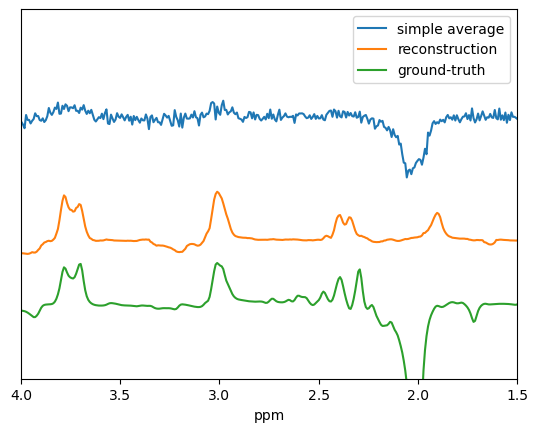

In [10]:
# creating test dataset and extracting a choosen scan
test_dataset = BasicDataset(x_test,y_test,ppm_test)

test_scan=15

sample_x_test,sample_gt_spec,sample_ppm = test_dataset.__getitem__(test_scan)


# calculating simple average of input data
raw_average = sample_x_test.unsqueeze(0).mean(axis=2)

# obtaining output from model
with torch.no_grad():
    pred = model(sample_x_test.unsqueeze(0).float().to(device)).to("cpu")

#plotting all results, with offset between for a better visualization
fig,ax = plt.subplots()

y_offset=0.3

ax.plot(sample_ppm,raw_average.detach().numpy().flatten()+2*y_offset,label="simple average")
ax.plot(sample_ppm,pred.detach().numpy().flatten()+y_offset*1,label="reconstruction")
ax.plot(sample_ppm,sample_gt_spec.detach().numpy().flatten(),label="ground-truth")


ax.set_ylim(-0.3,1.5)
ax.set_xlim(1.5,4)
ax.set_yticks([])
ax.set_xlabel("ppm")
ax.invert_xaxis()

plt.legend()
plt.show()

### Analyzing score of results

We'll use a script to calculate the metrics of our model.

In [11]:
import metric_calculator

pred = model.cpu()((x_test.float())).to("cpu")
raw_average = x_test.mean(axis=2)

print(raw_average.shape)
print(y_test.shape)
print(pred.shape)

#convert to numpy for compability
np_pred = pred.detach().numpy()
np_raw_average = raw_average.detach().numpy()
np_y_test = y_test.detach().numpy()


base_metrics = metric_calculator.calculate_metrics(np_raw_average.squeeze(2),np_y_test,ppm_test)
model_metrics = metric_calculator.calculate_metrics(np_pred,np_y_test,ppm_test)

print(f"Raw Average Metrics: {' - '.join(['{}:{:.2e}'.format(key,value) for key,value in base_metrics.items()])}")
print(f"----- Model Metrics: {' - '.join(['{}:{:.2e}'.format(key,value) for key,value in model_metrics.items()])}")

torch.Size([40, 2048, 1])
torch.Size([40, 2048])
torch.Size([40, 2048])
Raw Average Metrics: mse:9.62e-02 - snr:1.46e+01 - linewidth:2.61e-01 - shape_score:6.92e-01
----- Model Metrics: mse:7.06e-03 - snr:6.93e+01 - linewidth:9.58e-02 - shape_score:9.49e-01


### Saving submission

We'll now save the results in a h5 format for submission, sipposing the test data was stored in the x_test variable. 

In [14]:
pred = model(x_test.float()).reshape(pred.shape[0],-1)

from utils import save_submission
# converting to numpy before saving in file
save_submission(pred.detach().numpy(),ppm_test.numpy(),"sample_submissions/torch_submission.h5")

/home/rodrigo/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([40, 2048])
